# Tareas

1. $\langle E \rangle_{rad}^0\langle \sigma v \rangle_{rad}^0$ Gráficar tabla II de lechte en func temp, y comparar con los obtenidados de Cherab.
2. Construir el  $\langle E \rangle_{ion}\langle \sigma v \rangle_{ion}$ de la eq. 14 de Lechte (cuidado m^3 / s) y hacer plot de temperaturas. Comparar con los datos obtenidos de cherab.
3. Tratar de hacer lo mismo con el Helio.
4. Encontrar los términos $\langle E \rangle_{rec}\langle \sigma v \rangle_{rec}$, $\langle E \rangle_{ion_2}\langle \sigma v \rangle_{ion_2}$ y $\langle E \rangle_{rad}^i\langle \sigma v \rangle_{rad}^i$.

## Condiciones de Frontera
* Definir condiciones de frontera clásicas (las más sencillas) que nos permitan generar las funciones, pensando en el entrenamiento del PINN. Ej, elegir temperatura y densidad fijas en frontera. 
* Definir perfil de densidad y/o temperatura en la frontera que nos den libertad para parámetros que nos ayuden. 

### Casos:
1. Densidad y temperatura constante en los bordes
2. Gradiente de temperatura y densidad constante en los bordes y núcleo cero.
3. Flujo de partículas en el borde Robin, Flujo de energía.

$$
\begin{cases}
    \nabla n (r)|_R \propto n(R)\\
    \nabla T(r) |_R \propto T(R)
\end{cases}
$$
4. Energía interna.

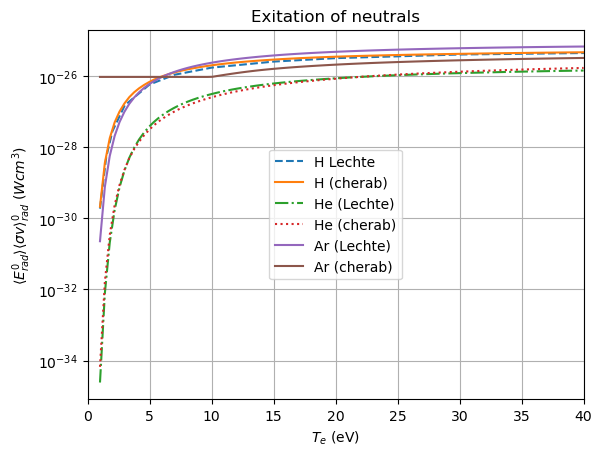

In [35]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

from cherab.core.atomic import hydrogen, helium, argon
from cherab.openadas import OpenADAS

#Function to compute the dissipate power
def Esigmav(Te, E, coeff_array):
    m = len(coeff_array)
    log_terms = np.array([ np.log(Te)**i for i in range(m) ])
    arg = np.dot(coeff_array, log_terms)

    return E*np.exp(arg)

#Datos tabla II
conv_fact = 1.6e-13
Te = np.array([1.,1.5,2.,3.,5.,7,10.,15.,20.,30.,50.,70.], dtype= np.float64)
EsigmavH_rad = np.array([1.87e-30, 5.14e-29, 2.8e-28, 1.51e-27, 5.81e-27, 1.09e-26, 1.73e-26, 2.56e-26, 3.2e-26, 4.05e-26, 4.9e-26, 5.27e-26])
E_rad = np.array([19.8, 11.5])
E_ion = [13.6, 24.6, 15.8]
T_array = np.linspace(1.0, 40.0, 100)

adas = OpenADAS(permit_extrapolation=True)

h_ion_rate = adas.ionisation_rate(hydrogen, 0)
h_rate = np.array([ h_ion_rate.evaluate(1e19, T ) for T in T_array])

he_ion_rate = adas.ionisation_rate(helium, 0)
he_rate = np.array([ he_ion_rate.evaluate(1e19, T ) for T in T_array])

ar_ion_rate = adas.ionisation_rate(argon, 0)
ar_rate = np.array([ ar_ion_rate.evaluate(1e19, T ) for T in T_array])

h_rec = adas.recombination_rate(hydrogen, 1)
h_rec_rate = np.array([ h_rec.evaluate(1e19, T ) for T in T_array])

h_rad0 = adas.line_radiated_power_rate(hydrogen,0)
h_rad0_rate = np.array([ h_rad0.evaluate(1e19, T ) for T in T_array])

he_rad0 = adas.line_radiated_power_rate(helium,0)
he_rad0_rate = np.array([ he_rad0.evaluate(1e19, T ) for T in T_array])

ar_rad0 = adas.line_radiated_power_rate(argon, 0)
ar_rad0_rate = np.array([ ar_rad0.evaluate(1e19, T ) for T in T_array])

he_radi = adas.line_radiated_power_rate(helium,1)
he_radi_rate = np.array([ he_rad0.evaluate(1e19, T ) for T in T_array])

ar_radi = adas.line_radiated_power_rate(argon, 1)
ar_radi_rate = np.array([ ar_rad0.evaluate(1e19, T ) for T in T_array])

coeffs_ion = pl.read_csv('coeff_rad0.csv').to_numpy()

plt.plot(Te, EsigmavH_rad,'--', label='H Lechte')
plt.plot(T_array, 1e6*h_rad0_rate, label= 'H (cherab)')
plt.plot(T_array, Esigmav(T_array, E_rad[0] , coeffs_ion[:,0])*conv_fact, '-.',label='He (Lechte)');
plt.plot(T_array, 1e6*he_rad0_rate, ':',label='He (cherab)');
plt.plot(T_array, Esigmav(T_array, E_rad[1], coeffs_ion[:,1])*conv_fact, label='Ar (Lechte)');
plt.plot(T_array, 1e6*ar_rad0_rate,label='Ar (cherab)');
plt.yscale('log')
plt.xlabel(r'$T_e$ (eV)')
plt.title('Exitation of neutrals')
plt.xlim([0,40])
#plt.ylim([1e-30,1e-25])
plt.ylabel(r'$\langle E_{rad}^0 \rangle\langle \sigma v \rangle_{rad}^0$ ($W cm^3$)');
plt.legend(loc='center');
plt.grid(True)

### En la figura anterior se forzaron los factes para que calzaran, tengo que averiguar por que hay un factor de $10^6$ ahí.

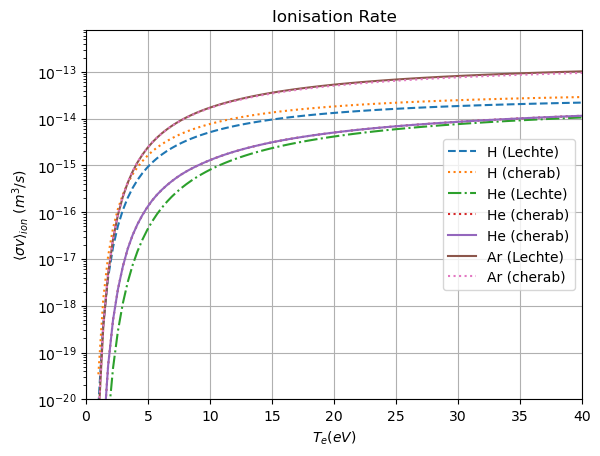

In [20]:
coeffs_ion = pl.read_csv('coeff_ion.csv').to_numpy()

plt.plot(T_array, Esigmav(T_array, 1, coeffs_ion[:,0]),'--', label='H (Lechte)');
plt.plot(T_array, h_rate, ':',label='H (cherab)');
plt.plot(T_array, Esigmav(T_array, 1, coeffs_ion[:,1]), '-.',label='He (Lechte)');
plt.plot(T_array, he_rate, label='He (cherab)')
plt.plot(T_array, Esigmav(T_array, 1, coeffs_ion[:,2]), label='Ar (Lechte)');
plt.plot(T_array, ar_rate,':', label='Ar (cherab)')
plt.ylabel(r'$\langle \sigma v\rangle_{ion}$ $(m^3/s)$')
plt.xlabel(r'$T_e(eV)$')
plt.yscale('log')
plt.ylim([1e-20,8e-13])
plt.xlim([0,40])
plt.title('Ionisation Rate')
plt.legend(loc='center right')
plt.grid(True)

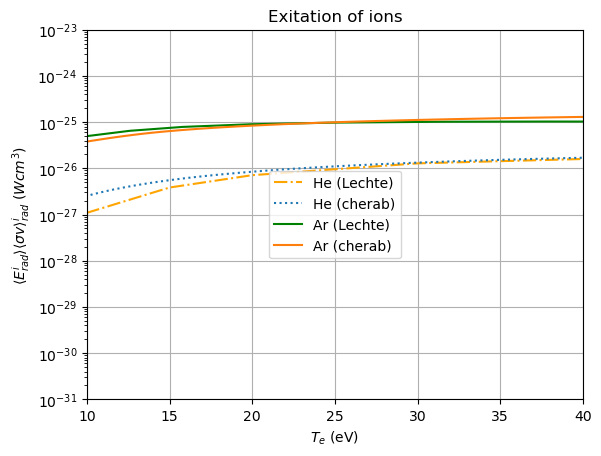

In [42]:
TeHe = np.array([0.2,0.3,0.5,0.7,1.0,1.5,2.0,3.0,5.0,7.0,10.0,15.0,20.0,30.0,50.0,70.0])
TeAr = np.array([1.,1.26,1.58,1.99,2.51,3.16,3.98,5.01,6.31,7.94,9.99,12.6,15.8,19.9,25.1,31.6,37.8,50.1,63.,79.4])
EsigmavHe_radi = np.array([1.0e-74, 1.0e-74, 2.33e-61, 6.68e-51, 2.4e-43,2.1e-37,1.41e-34,1.14e-31, 2.21e-29, 2.08e-28,1.09e-27,3.84e-27, 7.11e-27,1.28e-26,1.98e-26,2.34e-26])
EsigmavAr_radi = np.array([3.72e-31, 4.79e-30, 3.69e-29,  1.92e-28, 7.43e-28, 2.27e-27, 5.68e-27,1.20e-26,2.17e-26,3.47e-26, 4.97e-26, 6.49e-26, 7.88e-26, 8.99e-26, 9.77e-26, 1.02e-25, 1.03e-25,1.02e-25, 9.82e-26, 9.33e-26])

plt.plot(TeHe, EsigmavHe_radi, '-.', color='orange',label='He (Lechte)');
plt.plot(T_array, 1e6*he_radi_rate, ':',label='He (cherab)');
plt.plot(TeAr, EsigmavAr_radi, 'g', label='Ar (Lechte)');
plt.plot(T_array, 4e6*ar_radi_rate,label='Ar (cherab)');
plt.yscale('log')
plt.xlabel(r'$T_e$ (eV)')
plt.title('Exitation of ions')
plt.xlim([10,40])
plt.ylim([1e-31, 1e-23])
plt.ylabel(r'$\langle E_{rad}^i \rangle\langle \sigma v \rangle_{rad}^i$ ($W cm^3$)');
plt.legend(loc='center');
plt.grid(True)

### En la figura anterior se forzaron los factes para que calzaran, tengo que averiguar por que hay un factor de $10^6$ ahí.

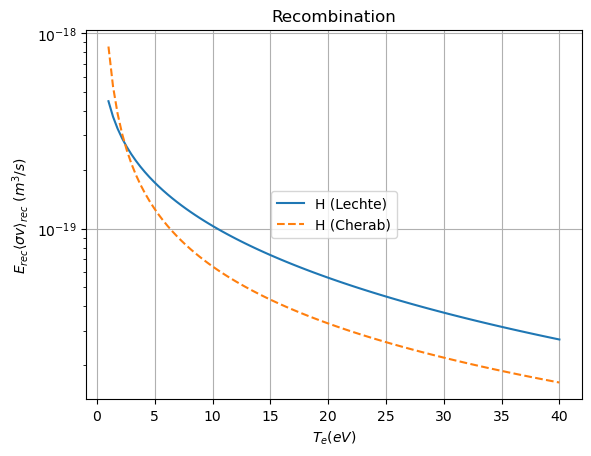

In [45]:
def sigmav_rec(Te):
    Z = 13.6 / Te
    return 1.27e-19*np.pow(Z, 1.5) / (Z + 0.59) 

plt.plot(T_array, sigmav_rec(T_array), label='H (Lechte)');
plt.plot(T_array, h_rec_rate, '--',label='H (Cherab)');
plt.ylabel(r'$E_{rec}\langle \sigma v\rangle_{rec}$ $(m^3/s)$')
plt.xlabel(r'$T_e(eV)$')
plt.yscale('log')
plt.title('Recombination')
plt.legend(loc='center')
plt.grid(True)